In [1]:
import os
import pandas as pd
import numpy as np
import gdown
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir('../')

In [3]:
url = 'https://drive.google.com/uc?/export=download&id=1F-07wKd5ymbEDvW5G_9su2pbtBnGIms3'
gdown.download(url, 'data/raw/data.csv')

Downloading...
From: https://drive.google.com/uc?/export=download&id=1F-07wKd5ymbEDvW5G_9su2pbtBnGIms3
To: /Users/ernestodavidserizeportela/WorkSpace/LGI-predictor/data/raw/data.csv
100%|██████████| 23.6k/23.6k [00:00<00:00, 31.3kB/s]


'data/raw/data.csv'

In [4]:
data = pd.read_csv('data/raw/data.csv')

In [5]:
drops = ['Unnamed: 0', 'Complicaciones', 'Diagnóstico', 'EDAD-R']

In [6]:
data.drop(columns=drops, axis=1, inplace=True)

Text(0, 0.5, 'Frequency')

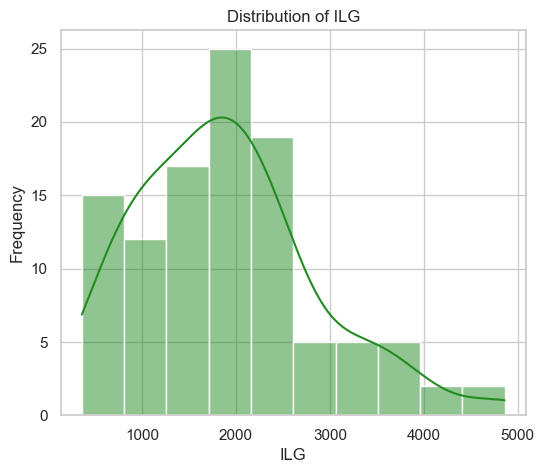

In [7]:
plt.figure(figsize=(6,5))
sns.set(style='whitegrid')
sns.histplot(data['ILG'], color='forestgreen', kde=True)
plt.title('Distribution of ILG')
plt.ylabel('Frequency')

In [8]:
cat_features = data.select_dtypes(include='object').columns
cat_features

Index(['Sexo', 'Estado al egreso'], dtype='object')

In [9]:
data['Sexo'] = data['Sexo'].map({'F': 0, 'M': 1})
data['Estado al egreso'] = data['Estado al egreso'].map({'F': 0, 'V': 1})

In [10]:
data[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Sexo              107 non-null    int64
 1   Estado al egreso  107 non-null    int64
dtypes: int64(2)
memory usage: 1.8 KB


In [11]:
X, y = data.drop('ILG', axis=1), data['ILG']

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=10)

selector.fit_transform(X, y)

features = X.columns[selector.get_support(indices=True)]
features

Index(['Leucocitos', 'Glucemia', 'Glucemia en  mg/dl', 'Estado al egreso',
       'insuficiencia venosa profunda', 'apnea del sueño', 'hipotiroidismo',
       'fa', 'esquizofrenia', 'tumor de ovarios'],
      dtype='object')

In [13]:
X = X[features]

In [14]:
matrix = X.join(y).corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))

Text(0.5, 1.0, 'Correlation Matrix Between Selected Features')

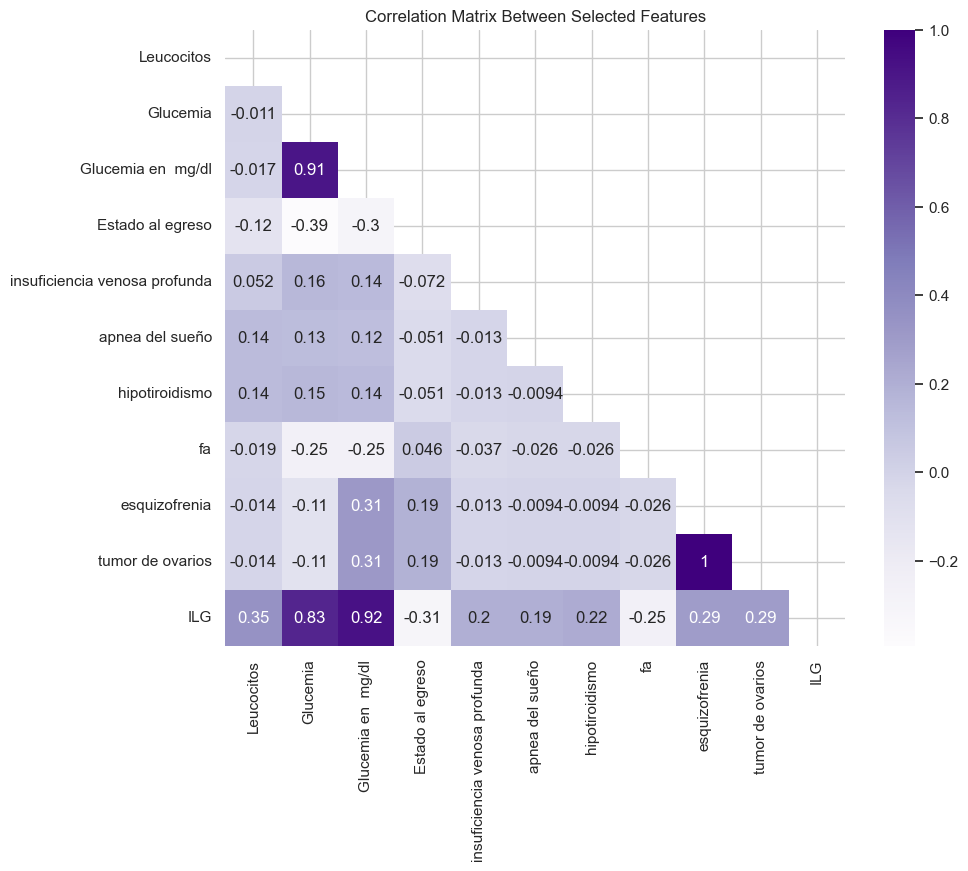

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='Purples', mask=mask)
plt.title('Correlation Matrix Between Selected Features')

In [16]:
X.drop(['Glucemia', 'tumor de ovarios', 'Estado al egreso'], axis=1, inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
normalizer = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

modelos_regresion = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    KNeighborsRegressor(),
    GaussianProcessRegressor()
]

In [19]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for modelo in modelos_regresion:
    scores = cross_val_score(modelo, X_scaled, y, scoring='neg_mean_squared_error', cv=kf)
    rmse_scores = np.sqrt(-scores)
    print(f"{modelo.__class__.__name__} - RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")


LinearRegression - RMSE: 155.50 ± 43.29
Ridge - RMSE: 158.08 ± 46.73
Lasso - RMSE: 155.21 ± 43.40
ElasticNet - RMSE: 390.93 ± 94.30
DecisionTreeRegressor - RMSE: 205.54 ± 65.84
RandomForestRegressor - RMSE: 178.14 ± 43.93
GradientBoostingRegressor - RMSE: 172.98 ± 37.61
SVR - RMSE: 932.99 ± 148.09
KNeighborsRegressor - RMSE: 374.55 ± 121.20
GaussianProcessRegressor - RMSE: 814.90 ± 326.74


In [20]:
params = {
    'alpha': np.logspace(-6, 6, 13), 
    'max_iter': [1000, 5000, 10000],
    'tol': [1e-4, 1e-3, 1e-2]
}

In [21]:
from sklearn.model_selection import GridSearchCV

reg = Lasso()

grid = GridSearchCV(estimator=reg, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_scaled, y)

print('Best score: ', np.sqrt(-grid.best_score_))
print('Best params: ' , grid.best_params_)

Best score:  141.68234432977977
Best params:  {'alpha': 1e-06, 'max_iter': 1000, 'tol': 0.0001}


/var/folders/z2/x55d_0sd3zl143hy_l05bnpr0000gn/T/ipykernel_32191/223033036.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df, y=X.columns, palette='plasma')


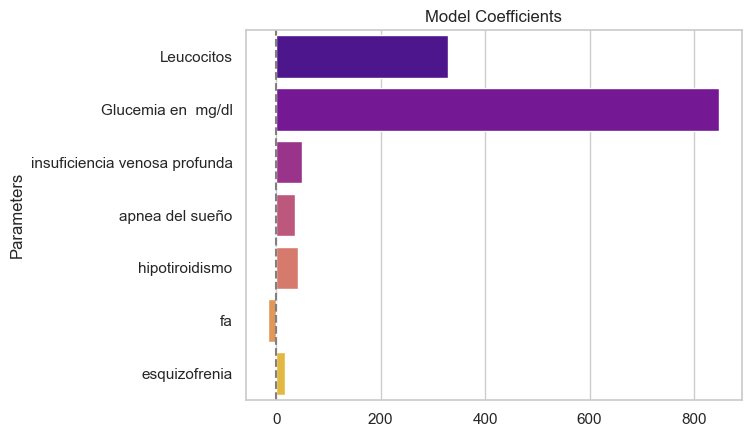

In [22]:
coef_df = grid.best_estimator_.coef_

sns.barplot(x=coef_df, y=X.columns, palette='plasma')
plt.title('Model Coefficients')
plt.ylabel('Parameters')
plt.axvline(0, color='grey', linestyle='--')

In [29]:
import json

coef = dict()

for i in range(7):
    coef[X.columns[i]] = coef_df[i]

with open('coeffs.json', 'w') as f:
    json.dump(coef, f, indent=3)

In [32]:
data = X.join(y)
data.to_csv('data/processed/data.csv', index=False)